In [1]:
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Activation
from keras import optimizers, regularizers
from keras.metrics import sparse_top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

Using TensorFlow backend.


In [2]:
ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')

In [3]:
# DEFINE DATES FOR SPLITTING AND SET UP DATASETS

### SETUP THE MARGINS OF DATASET
startDate = "2013-01-01 00:00:00"
endDate = "2015-04-22 00:00:00"

# define a threshold date in order to divide the whole set into the training, the validation set and the test set
validation_date = "2015-04-01 00:00:00"
test_date = "2015-04-15 00:00:00"

In [4]:
"""
This function:
1. converts the timestamp (seconds) in a date format as dd/MM/yyyy HH:mm:ss
2. sort ratings based on the timestamps
3. keep only the ratings that are above 4 (like bought products by users)
4. convert these ratings to 1.0
5. filter to keep only the dates after startingDate and before endingDate
"""

def transform_dataset(ratings_df, startingDate, endingDate):
    # convert timestampe to specific format
    ratings_df.timestamp =  pd.to_datetime(ratings_df.timestamp, unit = 's')
    # create a time series for the movies/products/ratings
    ratings_df = ratings_df.sort_values('timestamp')
    # keep the ratings above 4 (like they are the bought products)
    ratings_df = ratings_df[ratings_df.rating >= 4]
    # replace ratings above four with 1
    ratings_df.rating = 1
    # keep only the ratings after the specified date
    ratings_df = ratings_df[(ratings_df.timestamp >= startingDate) & (ratings_df.timestamp <= endingDate)]
    
    return ratings_df

In [5]:
# TRANSFORM DATASET
ratings_dataset_df = transform_dataset(ratings_df, startDate, endDate)

In [6]:
def split_sets(ratings_df, validationDate, testDate):
    training_set_df = ratings_df[ratings_df.timestamp < validationDate]
    validation_set_df = ratings_df[(ratings_df.timestamp >= validationDate) & (ratings_df.timestamp < testDate)]
    test_set_df = ratings_df[ratings_df.timestamp >= testDate]

    return (training_set_df, validation_set_df, test_set_df)

In [7]:
# SPLITTING
training_set_df, validation_set_df, test_set_df = split_sets(ratings_dataset_df, validation_date, test_date)

In [8]:
trainingUsers = training_set_df.userId.unique()
trainingMovies = training_set_df.movieId.unique()
validationUsers = validation_set_df.userId.unique()
validationMovies = validation_set_df.movieId.unique()
testUsers = test_set_df.userId.unique()
testMovies = test_set_df.movieId.unique()

In [9]:
vocabulary = training_set_df.movieId.unique()
vocabulary_size = len(vocabulary) + 2 # include zero and -1

vocabulary_dict = dict()
vocabulary_dict[0] = 0
vocabulary_dict[-1] = vocabulary_size - 1

for i in range(1, vocabulary_size - 1):
    vocabulary_dict[vocabulary[i-1]] = i

In [10]:
# length of the sequence , other values can be from the list [20, 50, 100]
# however the average length of the training sequences is 36
number_of_timesteps = 35 

In [11]:
# construct dictionary for training users
# used the reindexed movie ids in the sequences 
# as it is in vocabulary_dict

training_dict = dict()

for userId in trainingUsers:  
    length_of_sequence = 0
    user = training_set_df[training_set_df.userId == userId]
    user_movies = user.iloc[-(number_of_timesteps + 1):].movieId.values.tolist()
    length_of_sequence = len(user_movies)
    
    if length_of_sequence < number_of_timesteps + 1:
        zeros = (number_of_timesteps + 1 - length_of_sequence) * [0]
        user_movies = zeros + user_movies

    final_user_movies = list()

    for i in range(len(user_movies)):
        movie = user_movies[i]
        final_user_movies.append(vocabulary_dict[movie])

    training_dict[userId] = final_user_movies
    
training_df = pd.DataFrame(training_dict)
final_training_df = training_df.transpose()
#final_training_df

user_movies_training_matrix = final_training_df.as_matrix()
#print(user_movies_training_matrix.shape)

In [12]:
validation_dict = dict()

for userId in validationUsers:
    length_of_sequence = 0
    validationUser = validation_set_df[validation_set_df.userId == userId]    
    lastValMovies = validationUser.iloc[-(number_of_timesteps+1):].movieId.values # take last #num_timesteps movies if they exist
    length_of_sequence = len(lastValMovies)

    if length_of_sequence < number_of_timesteps + 1:
        trainingUser = training_set_df[training_set_df.userId == userId]
        lastTrainMovies = trainingUser.iloc[-(number_of_timesteps + 1 - length_of_sequence):].movieId.values
        user_movies = np.append(lastTrainMovies, lastValMovies).tolist()
    else:
        user_movies = lastValMovies.tolist()

    length_of_sequence = len(user_movies)

    if length_of_sequence < number_of_timesteps + 1:
        zeros = (number_of_timesteps + 1 - length_of_sequence) * [0]
        user_movies = zeros + user_movies

    final_user_movies = list()
    
    for i in range(len(user_movies)):
        movie = user_movies[i]
        if movie in vocabulary or movie == 0:
            final_user_movies.append(vocabulary_dict[movie])
        else:
            final_user_movies.append(vocabulary_size - 1)
    
    validation_dict[userId] = final_user_movies
    
validation_df = pd.DataFrame(validation_dict)
final_validation_df = validation_df.transpose()
#final_validation_df

user_movies_validation_matrix = final_validation_df.as_matrix()
#print(user_movies_validation_matrix.shape)

In [13]:
test_dict = dict()

for userId in testUsers:
    length_of_sequence = 0
    testUser = test_set_df[test_set_df.userId == userId]    
    lastTestMovies = testUser.iloc[-(number_of_timesteps + 1):].movieId.values.tolist() # take last #num_timesteps movies if they exist
    length_of_sequence = len(lastTestMovies)
    
    if length_of_sequence < number_of_timesteps + 1:
        validationUser = validation_set_df[validation_set_df.userId == userId]
        lastValMovies = validationUser.iloc[-(number_of_timesteps + 1 - length_of_sequence):].movieId.values.tolist()
        user_movies = lastValMovies + lastTestMovies
    else:
        user_movies = lastTestMovies
    
    length_of_sequence = len(user_movies)

    if length_of_sequence < number_of_timesteps + 1:
        trainingUser = training_set_df[training_set_df.userId == userId]
        lastTrainMovies = trainingUser.iloc[-(number_of_timesteps + 1 - length_of_sequence):].movieId.values.tolist()
        user_movies = lastTrainMovies + user_movies

    length_of_sequence = len(user_movies)

    if length_of_sequence < number_of_timesteps + 1:
        zeros = (number_of_timesteps + 1 - length_of_sequence) * [0]
        user_movies = zeros + user_movies

    final_user_movies = list()
    
    for i in range(len(user_movies)):
        movie = user_movies[i]
        if movie in vocabulary or movie == 0:
            final_user_movies.append(vocabulary_dict[movie])
        else:
            final_user_movies.append(vocabulary_size - 1)
    
    test_dict[userId] = final_user_movies
    
test_df = pd.DataFrame(test_dict)
final_test_df = test_df.transpose()
#final_test_df

user_movies_test_matrix = final_test_df.as_matrix()
#print(user_movies_test_matrix.shape)

In [14]:
### for both of these we need to reindex the movieIds for the embedding layer
X_train = user_movies_training_matrix[:, :-1] # matrix
y_train = user_movies_training_matrix[:, -1:] # movieIds from the training set
print(X_train.shape)
print(y_train.shape)
### the same for validation
X_val = user_movies_validation_matrix[:, :-1]
y_val = user_movies_validation_matrix[:, -1:]
### the same for test
X_test = user_movies_test_matrix[:, :-1]
y_test = user_movies_test_matrix[:, -1:]

(21033, 35)
(21033, 1)


In [15]:
def top_10_accuracy(y_true, y_pred): #sps@k
    # you can change k if you want a different number of recommendations
    return sparse_top_k_categorical_accuracy(y_true, y_pred, k = 10)

In [17]:
hidden_size_list = [8, 20, 40, 60, 80, 100]
num_steps = number_of_timesteps # timesteps -> be carefull if you change the timesteps
NUM_EPOCHS = 50
BATCH_SIZE_list = [500, 1000, 5000]
learning_rate_list = [0.01, 0.001]
drop_list = [0.0, 0.5]
weightsl2_list = [0.0, 0.01, 0.1, 0.2, 0.5]
dec_list = [0.1, 0.5]
LSTMs = [1, 2, 3]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 8)             123624    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_1 (Dense)              (None, 15453)             139077    
_________________________________________________________________
activation_1 (Activation)    (None, 15453)             0         
Total params: 263,245
Trainable params: 263,245
Non-trainable params: 0
_________________________________________________________________
None
Train on 21033 samples, validate on 1322 samples
Epoch 1/50

Epoch 00001: val_top_10_accuracy improved from -inf to 0.05598, saving model to hidsize8_batch500_lr0.01_lstms1_dec0.1/best_model.hdf5
 - 22s - loss: 9.3355 - top_10_accuracy: 0.0421 - val_loss: 8.9567 

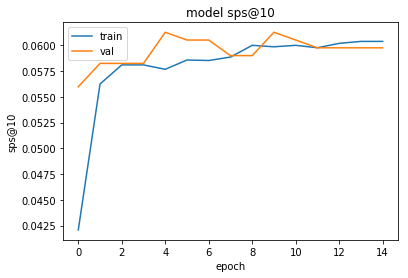

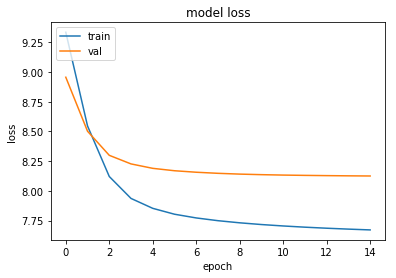

685/685 [==============================] - 0s 541us/step
Top 10 Accuracy TRAIN: 6.04%
Top 10 Accuracy VAL: 6.13%
Top 10 Accuracy TEST: 5.99%
diversity: 
11
Probabilities: 
[[1.20103505e-05 1.22082594e-04 2.94879923e-04 ... 1.18397020e-05
  1.17232894e-05 1.18852531e-05]
 [1.20102259e-05 1.22082391e-04 2.94880650e-04 ... 1.18395728e-05
  1.17231739e-05 1.18851294e-05]
 [1.20105060e-05 1.22082973e-04 2.94879486e-04 ... 1.18398439e-05
  1.17234413e-05 1.18853959e-05]
 ...
 [1.20103559e-05 1.22082594e-04 2.94879923e-04 ... 1.18397011e-05
  1.17232948e-05 1.18852531e-05]
 [1.20102304e-05 1.22082391e-04 2.94880563e-04 ... 1.18395837e-05
  1.17231784e-05 1.18851412e-05]
 [1.21075900e-05 1.22343306e-04 2.94598489e-04 ... 1.19352244e-05
  1.18159578e-05 1.19818069e-05]]
0.0046468046
1.0681932e-05
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 8)             123624    
___

KeyboardInterrupt: 

In [18]:
for hidden_size in hidden_size_list:
    for BATCH_SIZE in BATCH_SIZE_list:
        for learning_rate in learning_rate_list:
            for drop in drop_list:
                for weightsl2 in weightsl2_list:
                    weightsReg = regularizers.l2(weightsl2)

                    for dec in dec_list:
                        for no_lstms in LSTMs:

                            model = Sequential()
                            model.add(Embedding(vocabulary_size, hidden_size, input_length = num_steps, embeddings_regularizer = weightsReg))
                            if no_lstms > 2:
                                model.add(LSTM(hidden_size, return_sequences = True, unroll = True, dropout = drop, kernel_regularizer = weightsReg))
                            if no_lstms > 1:
                                model.add(LSTM(hidden_size, return_sequences = True, unroll = True, dropout = drop, kernel_regularizer = weightsReg))
                            model.add(LSTM(hidden_size, unroll = True, dropout = drop, kernel_regularizer = weightsReg))
                            model.add(Dense(vocabulary_size, kernel_regularizer = weightsReg))
                            model.add(Activation('softmax'))

                            adam = optimizers.Adam(lr = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = dec, amsgrad = False)

                            model.compile(loss = 'sparse_categorical_crossentropy', optimizer = adam, metrics = [top_10_accuracy])

                            print(model.summary())

                            directory = 'hidsize{0}_batch{1}_lr{2}_lstms{3}'.format(hidden_size, BATCH_SIZE, learning_rate, no_lstms)

                            if drop != 0.0:
                                directory = directory + '_drop{0}'.format(drop)

                            if weightsl2 != 0.0:
                                directory = directory + '_weightsl2{0}'.format(weightsl2)

                            if dec != 0.0:
                                directory = directory + '_dec{0}'.format(dec)

                            if not os.path.exists(directory):
                                os.makedirs(directory)

                            # hidden_size, num_steps, BATCH_SIZE
                            filepath = '{0}/best_model.hdf5'.format(directory)
                            checkpoint = ModelCheckpoint(filepath, monitor = 'val_top_10_accuracy', verbose = 1, save_best_only = True, mode = 'auto', period = 1)

                            # put checkpoint inside the callback
                            early_stopping = EarlyStopping(monitor = 'val_top_10_accuracy', patience = 5, verbose = 1)

                            history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = NUM_EPOCHS, batch_size = BATCH_SIZE, verbose = 2, callbacks = [checkpoint, early_stopping], shuffle = True)
                            scorestrain = model.evaluate(X_train, y_train, verbose = 1)
                            scores = model.evaluate(X_val, y_val, verbose = 1)

                            print("Top 10 Accuracy TRAIN: %.2f%%" % (scorestrain[1]*100))
                            print("Top 10 Accuracy VAL: %.2f%%" % (scores[1]*100))

                            #plot

                            # summarize history for top 10 accuracy
                            plt.plot(history.history['top_10_accuracy'])
                            plt.plot(history.history['val_top_10_accuracy'])
                            plt.title('model sps@10')
                            plt.ylabel('sps@10')
                            plt.xlabel('epoch')
                            plt.legend(['train', 'val'], loc = 'upper left')
                            plt.savefig(directory + '/spsat10.pdf')
                            plt.show()

                            # summarize history for loss
                            plt.plot(history.history['loss'])
                            plt.plot(history.history['val_loss'])
                            plt.title('model loss')
                            plt.ylabel('loss')
                            plt.xlabel('epoch')
                            plt.legend(['train', 'val'], loc = 'upper left')
                            plt.savefig(directory + '/loss.pdf')
                            plt.show()

                            best_filepath = filepath
                            model.load_weights(best_filepath)

                            scorestrain = model.evaluate(X_train, y_train, verbose = 1)
                            scores = model.evaluate(X_val, y_val, verbose = 1)
                            scoresTest = model.evaluate(X_test, y_test, verbose = 1)

                            print("Top 10 Accuracy TRAIN: %.2f%%" % (scorestrain[1]*100))
                            print("Top 10 Accuracy VAL: %.2f%%" % (scores[1]*100))
                            print("Top 10 Accuracy TEST: %.2f%%" % (scoresTest[1]*100))

                            print('diversity: ')
                            #### diversity of recommendations for the validation subset
                            recoms = list()
                            for n in range(X_val.shape[0]):
                                result = model.predict(X_val[n].reshape(X_val.shape[1], 1).T).flatten()
                                recoms = recoms + np.argsort(result)[-10:].tolist()

                            diversity_at_10 = len(set(recoms))
                            print(diversity_at_10)

                            val_result = model.predict(X_val)
                            print('Probabilities: ')
                            print(val_result)
                            print(np.max(val_result))
                            print(np.min(val_result))

In [19]:
best_filepath = filepath # put the filepath of the model, example filepath: 'hidsize8_batch500_lr0.01_lstms1_dec0.1/best_model.hdf5'
model.load_weights(best_filepath)
scorestrain = model.evaluate(X_train, y_train, verbose = 1)
scores = model.evaluate(X_val, y_val, verbose = 1)
scoresTest = model.evaluate(X_test, y_test, verbose = 1)

print("Top 10 Accuracy TRAIN: %.2f%%" % (scorestrain[1]*100))
print("Top 10 Accuracy VAL: %.2f%%" % (scores[1]*100))
print("Top 10 Accuracy TEST: %.2f%%" % (scoresTest[1]*100))

#### diversity of recommendations for the test subset
recoms = list()
for n in range(X_test.shape[0]):
    result = model.predict(X_test[n].reshape(X_test.shape[1], 1).T)
    final_result = result.flatten()
    recoms = recoms + np.argsort(final_result)[-10:].tolist()

fin = set(recoms)
print(len(fin))

OSError: Unable to open file (unable to open file: name = 'hidsize8_batch500_lr0.01_lstms2_dec0.1/best_model.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)